# "LightGBM on GPU with Feature Engineering, Optuna, and , Visualization"
1. Author: [@Satoru Shibata/柴田 怜](https://www.kaggle.com/satorushibata)
1. The original author: [@tito](https://www.kaggle.com/its7171)
  - I forked and edited [whose Notebook](https://www.kaggle.com/its7171/lgbm-with-loop-feature-engineering).
1. See [my Kernel Notebook: "LightGBM with the Inference & Empirical analysis"](https://www.kaggle.com/satorushibata/lightgbm-with-the-inference-empirical-analysis) on prediction and submission.

# Abstract:
1. [Riiid! Answer Correctness Prediction](https://www.kaggle.com/c/riiid-test-answer-prediction/overview)
1. This is a Code Competition
1. So, make the best model here and submit [this Kernel](https://www.kaggle.com/satorushibata/lgbm-with-loop-feature-engineering-optuna-plot)
1. I thank the original author, [@tito](https://www.kaggle.com/its7171).

# Use Google Colaboratory(GPU & 20GB) with Kaggle API:

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive')

In [4]:
!pip install -q kaggle --upgrade
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
# I need to set permissions
!chmod 600 ~/.kaggle/kaggle.json
# Find the competition name.
!kaggle competitions list

kaggle.json
ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         88            True  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        185           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        283           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2205            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      17441            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4653            Tru

# Maximize the memory of Python3:

In [5]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
# import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=cb25a92099ff13350a709c3f8d6b0ee48eee55a20f7d64a9810c640ebd6615c2
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 113.0 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


# Prepare the prerequisites:
## Work only for the first time.
- [Setting LightGBM with GPU on Google Colabratory](https://stackoverflow.com/questions/58707252/get-lightgbm-lgbm-run-with-gpu-on-google-colabratory)
- [Install LightGBM(BUILD GPU VERSION)](https://pypi.org/project/lightgbm/)

In [6]:
!pip install gc
!pip install sklearn
!pip install collections
!pip install tqdm
!pip install optuna
!pip install matplotlib
# To use GPU on LightGBM
!pip install lightgbm --install-option=--gpu
!git clone --recursive https://github.com/Microsoft/LightGBM
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

ERROR: Could not find a version that satisfies the requirement gc (from versions: none)
ERROR: No matching distribution found for gc
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
     |████████████████████████████████| 266kB 13.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 163kB 48.8MB/s 
     |████████████████████████████████| 133kB 47.6MB/s 
     |████████████████████████████████| 112kB 50.4MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
  Created wheel for optuna: filename=optuna-2.3.0-cp36-none-any.whl size=359761 sha256=b3bcdbaa4fc8157b9e846345c8119bf36d9e1cba49971e4ead0ceb6ec3b988fe
  Stored in directory: /root/.cache/pip/wheels/fa/

# Prepare to apply GPU to LightGBM:
- [GoogleColabratory + GradientBoosting + GPU](https://qiita.com/wakame1367/items/bcf8b760260329fb7136)

In [7]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM/
!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

fatal: destination path 'LightGBM' already exists and is not an empty directory.
[Errno 2] No such file or directory: '/content/LightGBM/'
/content
CMake Error: The source directory "/content/drive/My Drive" does not appear to contain CMakeLists.txt.
Specify --help for usage, or press the help button on the CMake GUI.
make: *** No targets specified and no makefile found.  Stop.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython-all-dev python-all python-all-dev python-asn1crypto
  python-cffi-backend python-crypto python-cryptography python-dbus
  python-enum34 python-gi python-idna python-ipaddress python-keyring
  python-keyrings.alt python-pip-whl python-pkg-resources python-secretstorage
  python-setuptools python-six python-wheel python-xdg
Suggested packages:
  python-crypto-doc python-cryptography-doc python-cryptography-vectors
  python-dbus-dbg python-dbus-doc python-e

# Run the Notebook referring to Kernel of Kaggle:
1. I created this file based on [this notebook](https://www.kaggle.com/its7171/lgbm-with-loop-feature-engineering);
1. And I am grateful for [the author, @tito](https://www.kaggle.com/its7171).

In [8]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from tqdm.notebook import tqdm
# Automate hyperparameter tuning for LightGBM
!pip install optuna
import optuna
from optuna.samplers import TPESampler
import lightgbm as lgb
from multiprocessing import cpu_count
from optuna.visualization import plot_optimization_history, plot_intermediate_values
# Plot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Save
import pickle
# Random seed
import random

In [9]:
# Make sure this notebook has completed to import LightGBM
print('Success:')
print('LightGBM version:', lgb.__version__)

Success:
LightGBM version: 3.1.1.99


# Initial conditions for LightGBM:

In [10]:
# Random seed
SEED = 123
sampler = TPESampler(seed=int(SEED))
# LightGBM
num_boost_round = int(300)
verbose_eval = num_boost_round // int(10)

# Boundary condition:

In [11]:
debug = False          # It were True, I have confirmed that AUC of validation is reduced.
validaten_flg = False

# Random seed
- [Riiid model LGBM](https://www.kaggle.com/ragnar123/riiid-model-lgbm)
- [Optunaのシード固定](https://qiita.com/si1242/items/d2f9195c08826d87d6ad#optuna%E3%81%AE%E3%82%B7%E3%83%BC%E3%83%89%E5%9B%BA%E5%AE%9A)
- [optuna.samplers.TPESampler](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html)

In [12]:
# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  
seed_everything(SEED)

## Setting:
CV files are generated by [this notebook](https://www.kaggle.com/its7171/cv-strategy)

In [13]:
train_pickle = 'cv1_train.pickle'
valid_pickle = 'cv1_valid.pickle'
question_file = 'questions.csv'

## Feature Engineering:

In [14]:
# funcs for user stats with loop
def add_user_feats(df, answered_correctly_sum_u_dict, count_u_dict):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    for cnt,row in enumerate(tqdm(df[['user_id','answered_correctly']].values)):
        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
        answered_correctly_sum_u_dict[row[0]] += row[1]
        count_u_dict[row[0]] += 1
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    return df

def add_user_feats_without_update(df, answered_correctly_sum_u_dict, count_u_dict):
    acsu = np.zeros(len(df), dtype=np.int32)
    cu = np.zeros(len(df), dtype=np.int32)
    for cnt,row in enumerate(df[['user_id']].values):
        acsu[cnt] = answered_correctly_sum_u_dict[row[0]]
        cu[cnt] = count_u_dict[row[0]]
    user_feats_df = pd.DataFrame({'answered_correctly_sum_u':acsu, 'count_u':cu})
    user_feats_df['answered_correctly_avg_u'] = user_feats_df['answered_correctly_sum_u'] / user_feats_df['count_u']
    df = pd.concat([df, user_feats_df], axis=1)
    return df

def update_user_feats(df, answered_correctly_sum_u_dict, count_u_dict):
    for row in df[['user_id','answered_correctly','content_type_id']].values:
        if row[2] == 0:
            answered_correctly_sum_u_dict[row[0]] += row[1]
            count_u_dict[row[0]] += 1

In [15]:
# read data
feld_needed = ['row_id', 'user_id', 'content_id', 'content_type_id', 'answered_correctly', 'prior_question_elapsed_time', 'prior_question_had_explanation']
train = pd.read_pickle(train_pickle)[feld_needed]
valid = pd.read_pickle(valid_pickle)[feld_needed]
if debug:
    train = train[:1000000]
    valid = valid[:10000]
train = train.loc[train.content_type_id == False].reset_index(drop=True)
valid = valid.loc[valid.content_type_id == False].reset_index(drop=True)

# answered correctly average for each content
content_df = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean']).reset_index()
content_df.columns = ['content_id', 'answered_correctly_avg_c']
train = pd.merge(train, content_df, on=['content_id'], how="left")
valid = pd.merge(valid, content_df, on=['content_id'], how="left")

# user stats features with loops
answered_correctly_sum_u_dict = defaultdict(int)
count_u_dict = defaultdict(int)
train = add_user_feats(train, answered_correctly_sum_u_dict, count_u_dict)
valid = add_user_feats(valid, answered_correctly_sum_u_dict, count_u_dict)

# fill with mean value for prior_question_elapsed_time
# note that `train.prior_question_elapsed_time.mean()` dose not work!
# please refer https://www.kaggle.com/its7171/can-we-trust-pandas-mean for detail.
prior_question_elapsed_time_mean = train.prior_question_elapsed_time.dropna().values.mean()
train['prior_question_elapsed_time_mean'] = train.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)
valid['prior_question_elapsed_time_mean'] = valid.prior_question_elapsed_time.fillna(prior_question_elapsed_time_mean)

# use only last 30M training data for limited memory on kaggle env.
#train = train[-30000000:]

# part
questions_df = pd.read_csv(question_file)
train = pd.merge(train, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')
valid = pd.merge(valid, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')

# changing dtype to avoid lightgbm error
train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')
valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')

In [16]:
TARGET = 'answered_correctly'
FEATS = ['answered_correctly_avg_u', 'answered_correctly_sum_u', 'count_u', 'answered_correctly_avg_c', 'part', 'prior_question_had_explanation', 'prior_question_elapsed_time']
dro_cols = list(set(train.columns) - set(FEATS))
y_tr = train[TARGET]
y_va = valid[TARGET]
train.drop(dro_cols, axis=1, inplace=True)
valid.drop(dro_cols, axis=1, inplace=True)
_=gc.collect()

In [17]:
lgb_train = lgb.Dataset(train[FEATS], y_tr)
lgb_valid = lgb.Dataset(valid[FEATS], y_va, reference = lgb_train)
del train, y_tr
_=gc.collect()

# Functions to plot the result of LightGBM:
- [ROC_AUC曲線の解説、実装と欠点](https://sammi-baba.hatenablog.com/entry/2019/07/28/195122)

In [18]:
def ROC_curve(y_true, y_pred):
  fpr, tpr, thred = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

# Tuning with Optuna:
- [Optuna/README.md](https://github.com/optuna/optuna/blob/master/README.md)
- [GPU acceleration for LightGBM](https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm/)
- [verbose_eval](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html)
- [Potting on LightGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html)
- [lgb.plot_split_value_histogram](https://www.kaggle.com/madiyar/ieee-fraud-lightgbm-split-value-histogram)
- [lgb.plot_metric](https://www.kaggle.com/tobikaggle/humble-lightgbm-starter-with-learning-curve)
- [lgb.plot_tree](https://www.kaggle.com/maria591/lightgbm)
- [lgb.create_tree_digraph](https://www.programmersought.com/article/794564372/)
- [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
- [evals_result](https://hk29.hatenablog.jp/entry/2019/12/31/172437)
- [Debug](https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/88681)
- [Bootstrap sampling](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.utils.resample.html)
- [LightGBMとOptunaを導入・動かしてみる](https://kiseno-log.com/2019/11/05/lightgbm%E3%81%A8optuna%E3%82%92%E5%B0%8E%E5%85%A5%E3%83%BB%E5%8B%95%E3%81%8B%E3%81%97%E3%81%A6%E3%81%BF%E3%82%8B/)
- [lightgbm.LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [19]:
# Make the model of LightGBM and plot results.
def LightGBM(params, lgb_train, lgb_valid, num_boost_round, verbose_eval, FEATS):
  # To record evaluation results for plotting
  evaluation_result = {}
  # Training
  model = lgb.train(params,
                    lgb_train,
                    valid_sets = [lgb_train, lgb_valid],
                    num_boost_round = num_boost_round,
                    verbose_eval = verbose_eval,
                    evals_result = evaluation_result
                    )
  # Predict to validate the model
  y_pred = model.predict(valid[FEATS], num_iteration=model.best_iteration)
  accuracy = roc_auc_score(y_va, y_pred, labels='ROC curve', average='weighted', multi_class='raise')
  print('ROC curve:', accuracy)
  ROC_curve(y_va, y_pred)
  # Plots
  lgb.plot_importance(model)
  plt.show()
  for feature in FEATS:
    lgb.plot_split_value_histogram(model, feature=feature)
    plt.show()
  lgb.plot_metric(evaluation_result, metric='auc')
  plt.show()
  lgb.plot_tree(model, figsize=(30, 50))
  plt.show()
  lgb.create_tree_digraph(model, tree_index=int(20), name='Tree digraph')
  plt.show()
  # Finish
  print("This function is completed.")
  # The result
  return model

In [20]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'AUC',
        'boosting_type': 'dart', # To improve AUC
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.1, 0.9),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 0.1, 0.9),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbose': 0
    }
    # Learning
    gbm = LightGBM(params, lgb_train, lgb_valid, num_boost_round, verbose_eval, FEATS)
    # Prediction
    y_pred = gbm.predict(valid[FEATS], num_iteration=gbm.best_iteration)
    accuracy = roc_auc_score(y_va, y_pred, labels='ROC curve', average='weighted')
    print('ROC curve:', accuracy)
    ROC_curve(y_va, y_pred)
    # Finish
    print("Operation completed.")
    # Output
    return accuracy

## Run Optuna:
- [optuna.study](https://optuna.readthedocs.io/en/stable/reference/study.html)
- [最適なパラメータを効率的に探索しちゃおっちゅうな(Optuna)](https://qiita.com/maskot1977/items/ed698a67b091b5516ab4#lightgbm--optuna)
- [プロセッサのコアの数を確認する](https://support.microsoft.com/ja-jp/windows/%E3%83%97%E3%83%AD%E3%82%BB%E3%83%83%E3%82%B5%E3%81%AE%E3%82%B3%E3%82%A2%E3%81%AE%E6%95%B0%E3%82%92%E7%A2%BA%E8%AA%8D%E3%81%99%E3%82%8B-3126ef99-0247-33b3-81fc-065e9fb0c35b)
- [Optunaでrandomのseedを固定する方法](https://qiita.com/phorizon20/items/1b795beb202c2dc378ed)
- [【機械学習実践】Optunaでパラメータチューニング【Python】](https://rin-effort.com/2019/12/30/machine-learning-7/)
- [n_jobs](https://blog.amedama.jp/entry/2018/12/06/015217)

[I 2020-12-23 06:40:28,519] A new study created in memory with name: no-name-11127265-4ad8-4700-a896-b248d75dfe89


[30]	training's auc: 0.750867	valid_1's auc: 0.760457
[30]	training's auc: 0.751853	valid_1's auc: 0.761303
[60]	training's auc: 0.751449	valid_1's auc: 0.760734
[60]	training's auc: 0.752394	valid_1's auc: 0.761553
[90]	training's auc: 0.751631	valid_1's auc: 0.76114
[90]	training's auc: 0.752612	valid_1's auc: 0.761848
[120]	training's auc: 0.751744	valid_1's auc: 0.7612
[120]	training's auc: 0.752743	valid_1's auc: 0.761929
[150]	training's auc: 0.75197	valid_1's auc: 0.761588
[150]	training's auc: 0.753011	valid_1's auc: 0.762249
[180]	training's auc: 0.752092	valid_1's auc: 0.761665
[180]	training's auc: 0.75315	valid_1's auc: 0.762159
[210]	training's auc: 0.752243	valid_1's auc: 0.761864
[240]	training's auc: 0.752414	valid_1's auc: 0.761957
[210]	training's auc: 0.753357	valid_1's auc: 0.762314
[270]	training's auc: 0.752597	valid_1's auc: 0.762098
[240]	training's auc: 0.753578	valid_1's auc: 0.762343
[300]	training's auc: 0.752715	valid_1's auc: 0.762187
ROC curve: 0.76218489

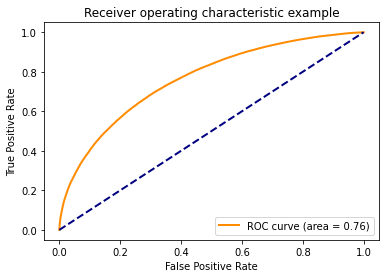

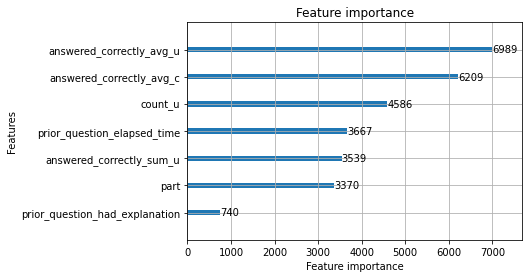

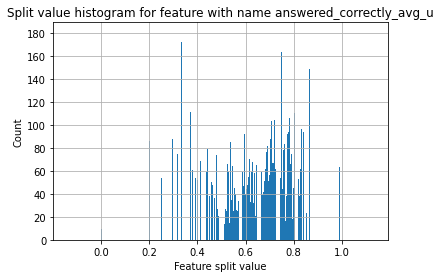

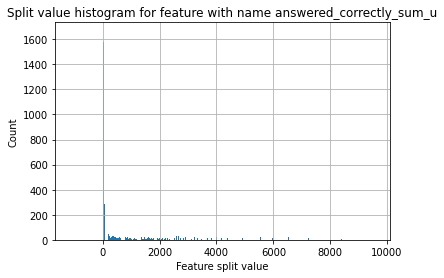

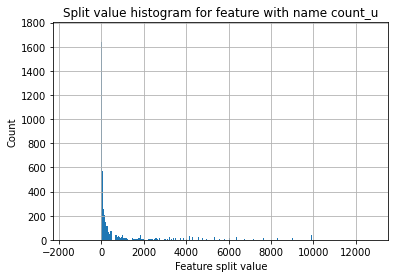

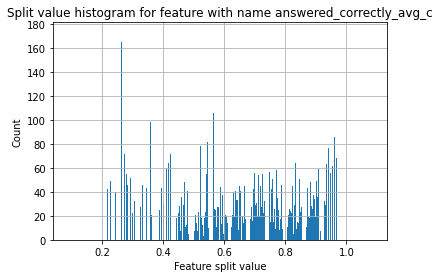

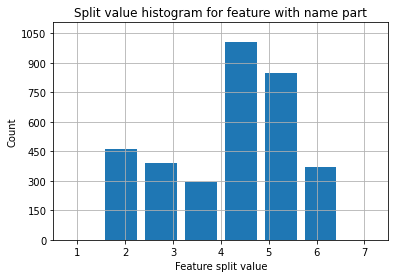

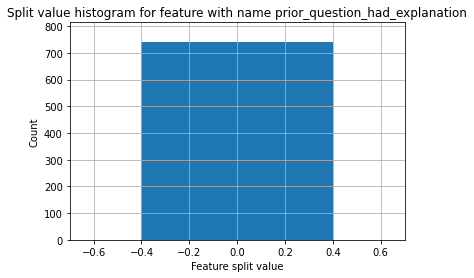

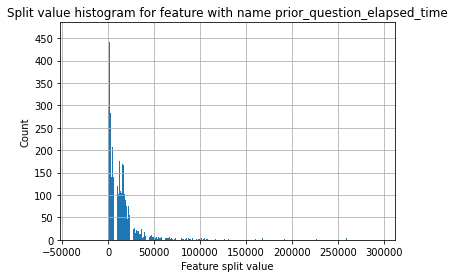

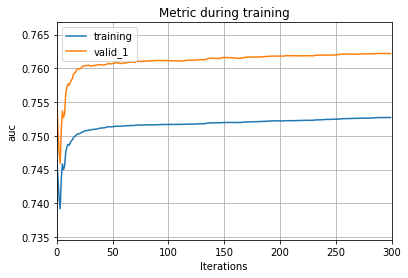

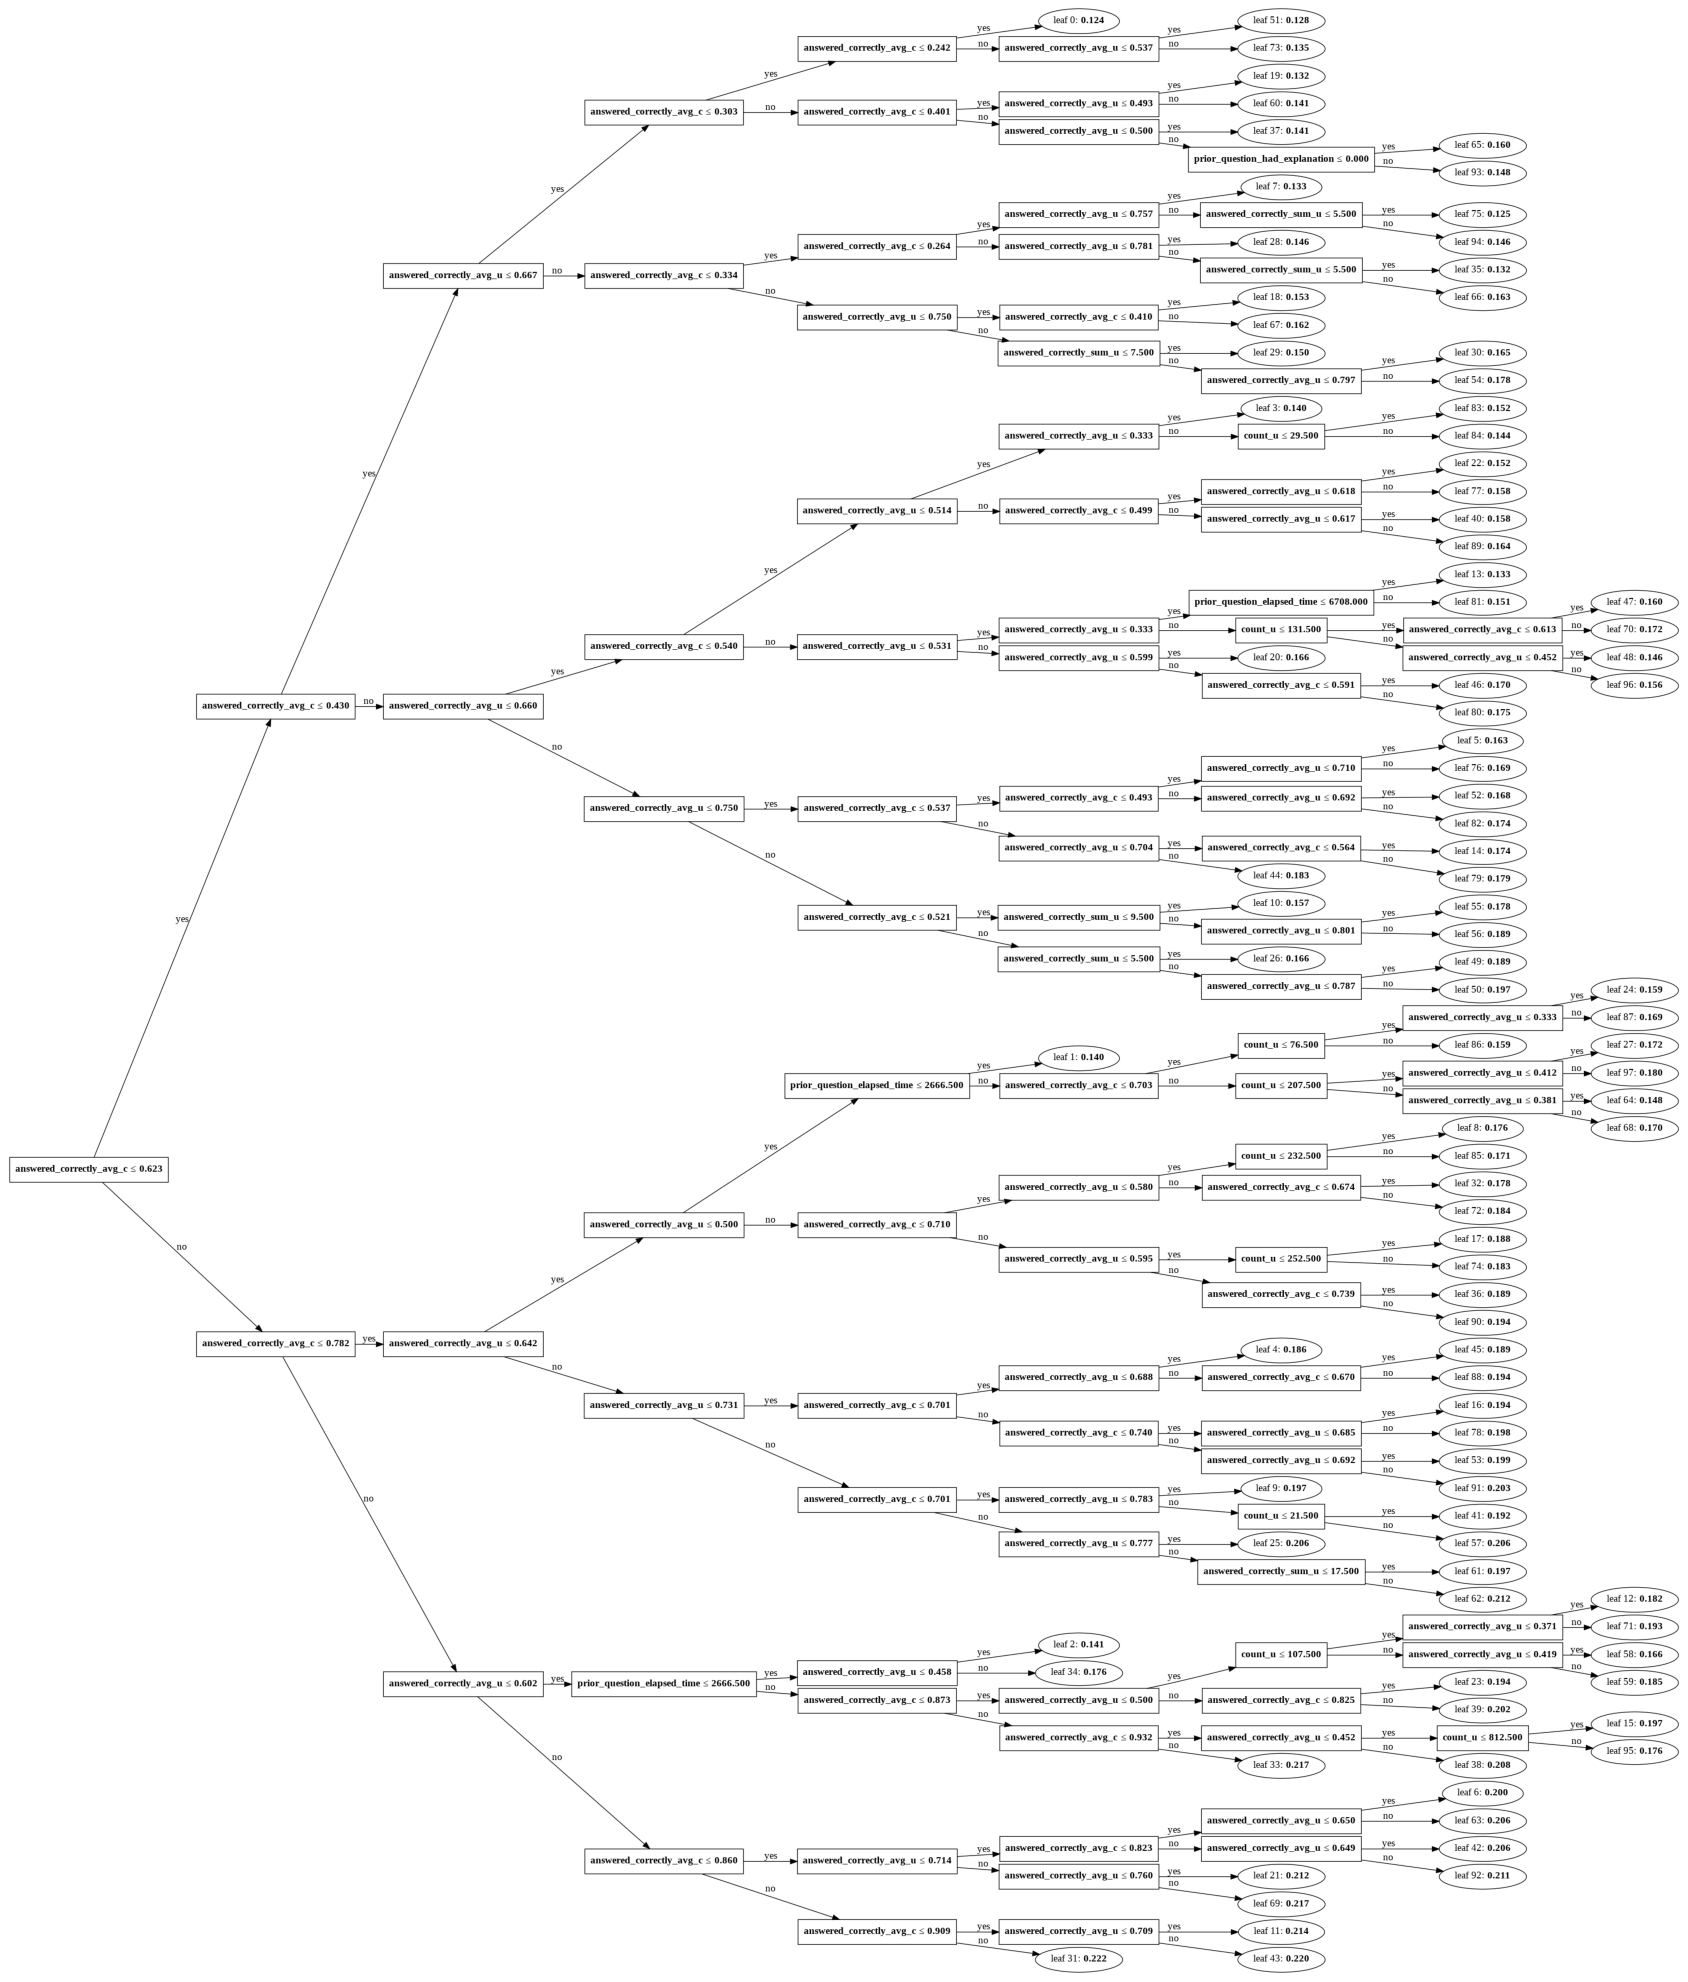

This function is completed.
ROC curve: 0.7621848946654868


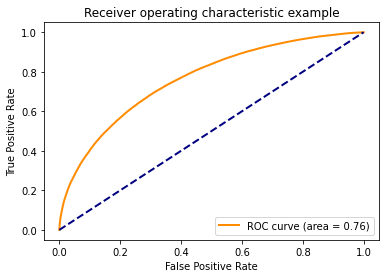

[I 2020-12-23 08:14:12,674] Trial 1 finished with value: 0.7621848946654868 and parameters: {'lambda_l1': 0.20250514349136498, 'lambda_l2': 0.14070658914801626, 'num_leaves': 98, 'feature_fraction': 0.8880314120241304, 'bagging_fraction': 0.5580738963120944, 'bagging_freq': 1, 'min_child_samples': 83}. Best is trial 1 with value: 0.7621848946654868.


Operation completed.
[270]	training's auc: 0.753871	valid_1's auc: 0.762437
[300]	training's auc: 0.754055	valid_1's auc: 0.762449
ROC curve: 0.7624459229799384


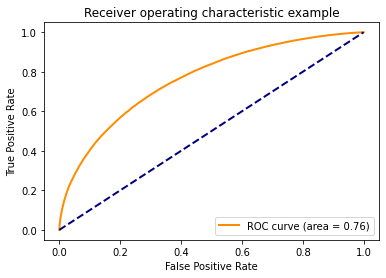

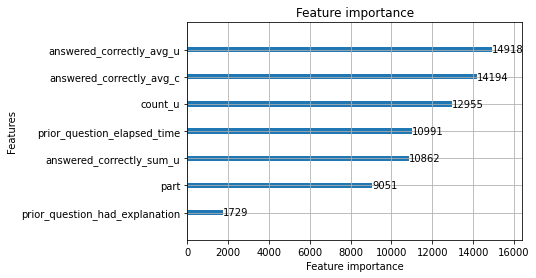

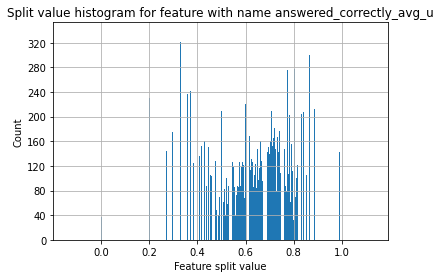

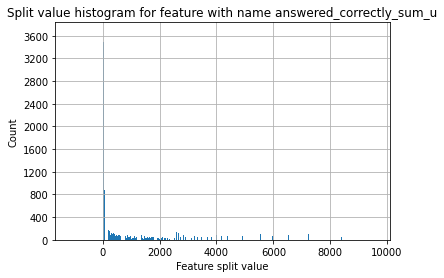

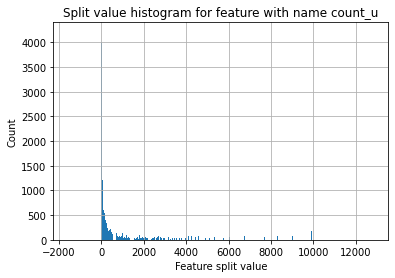

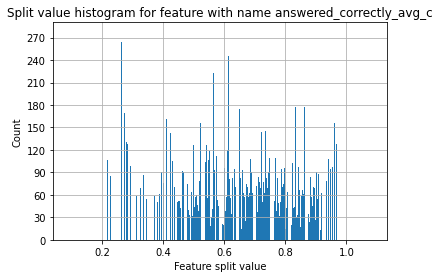

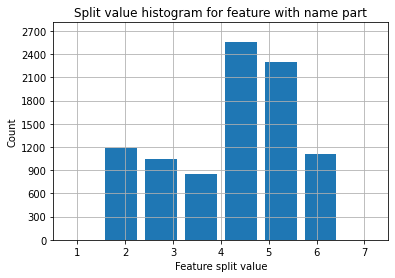

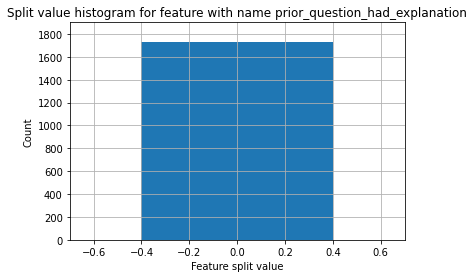

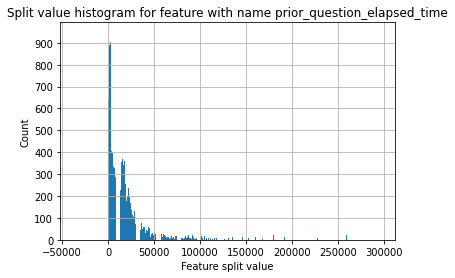

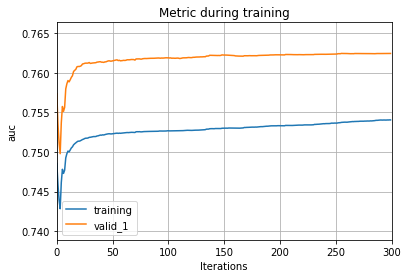

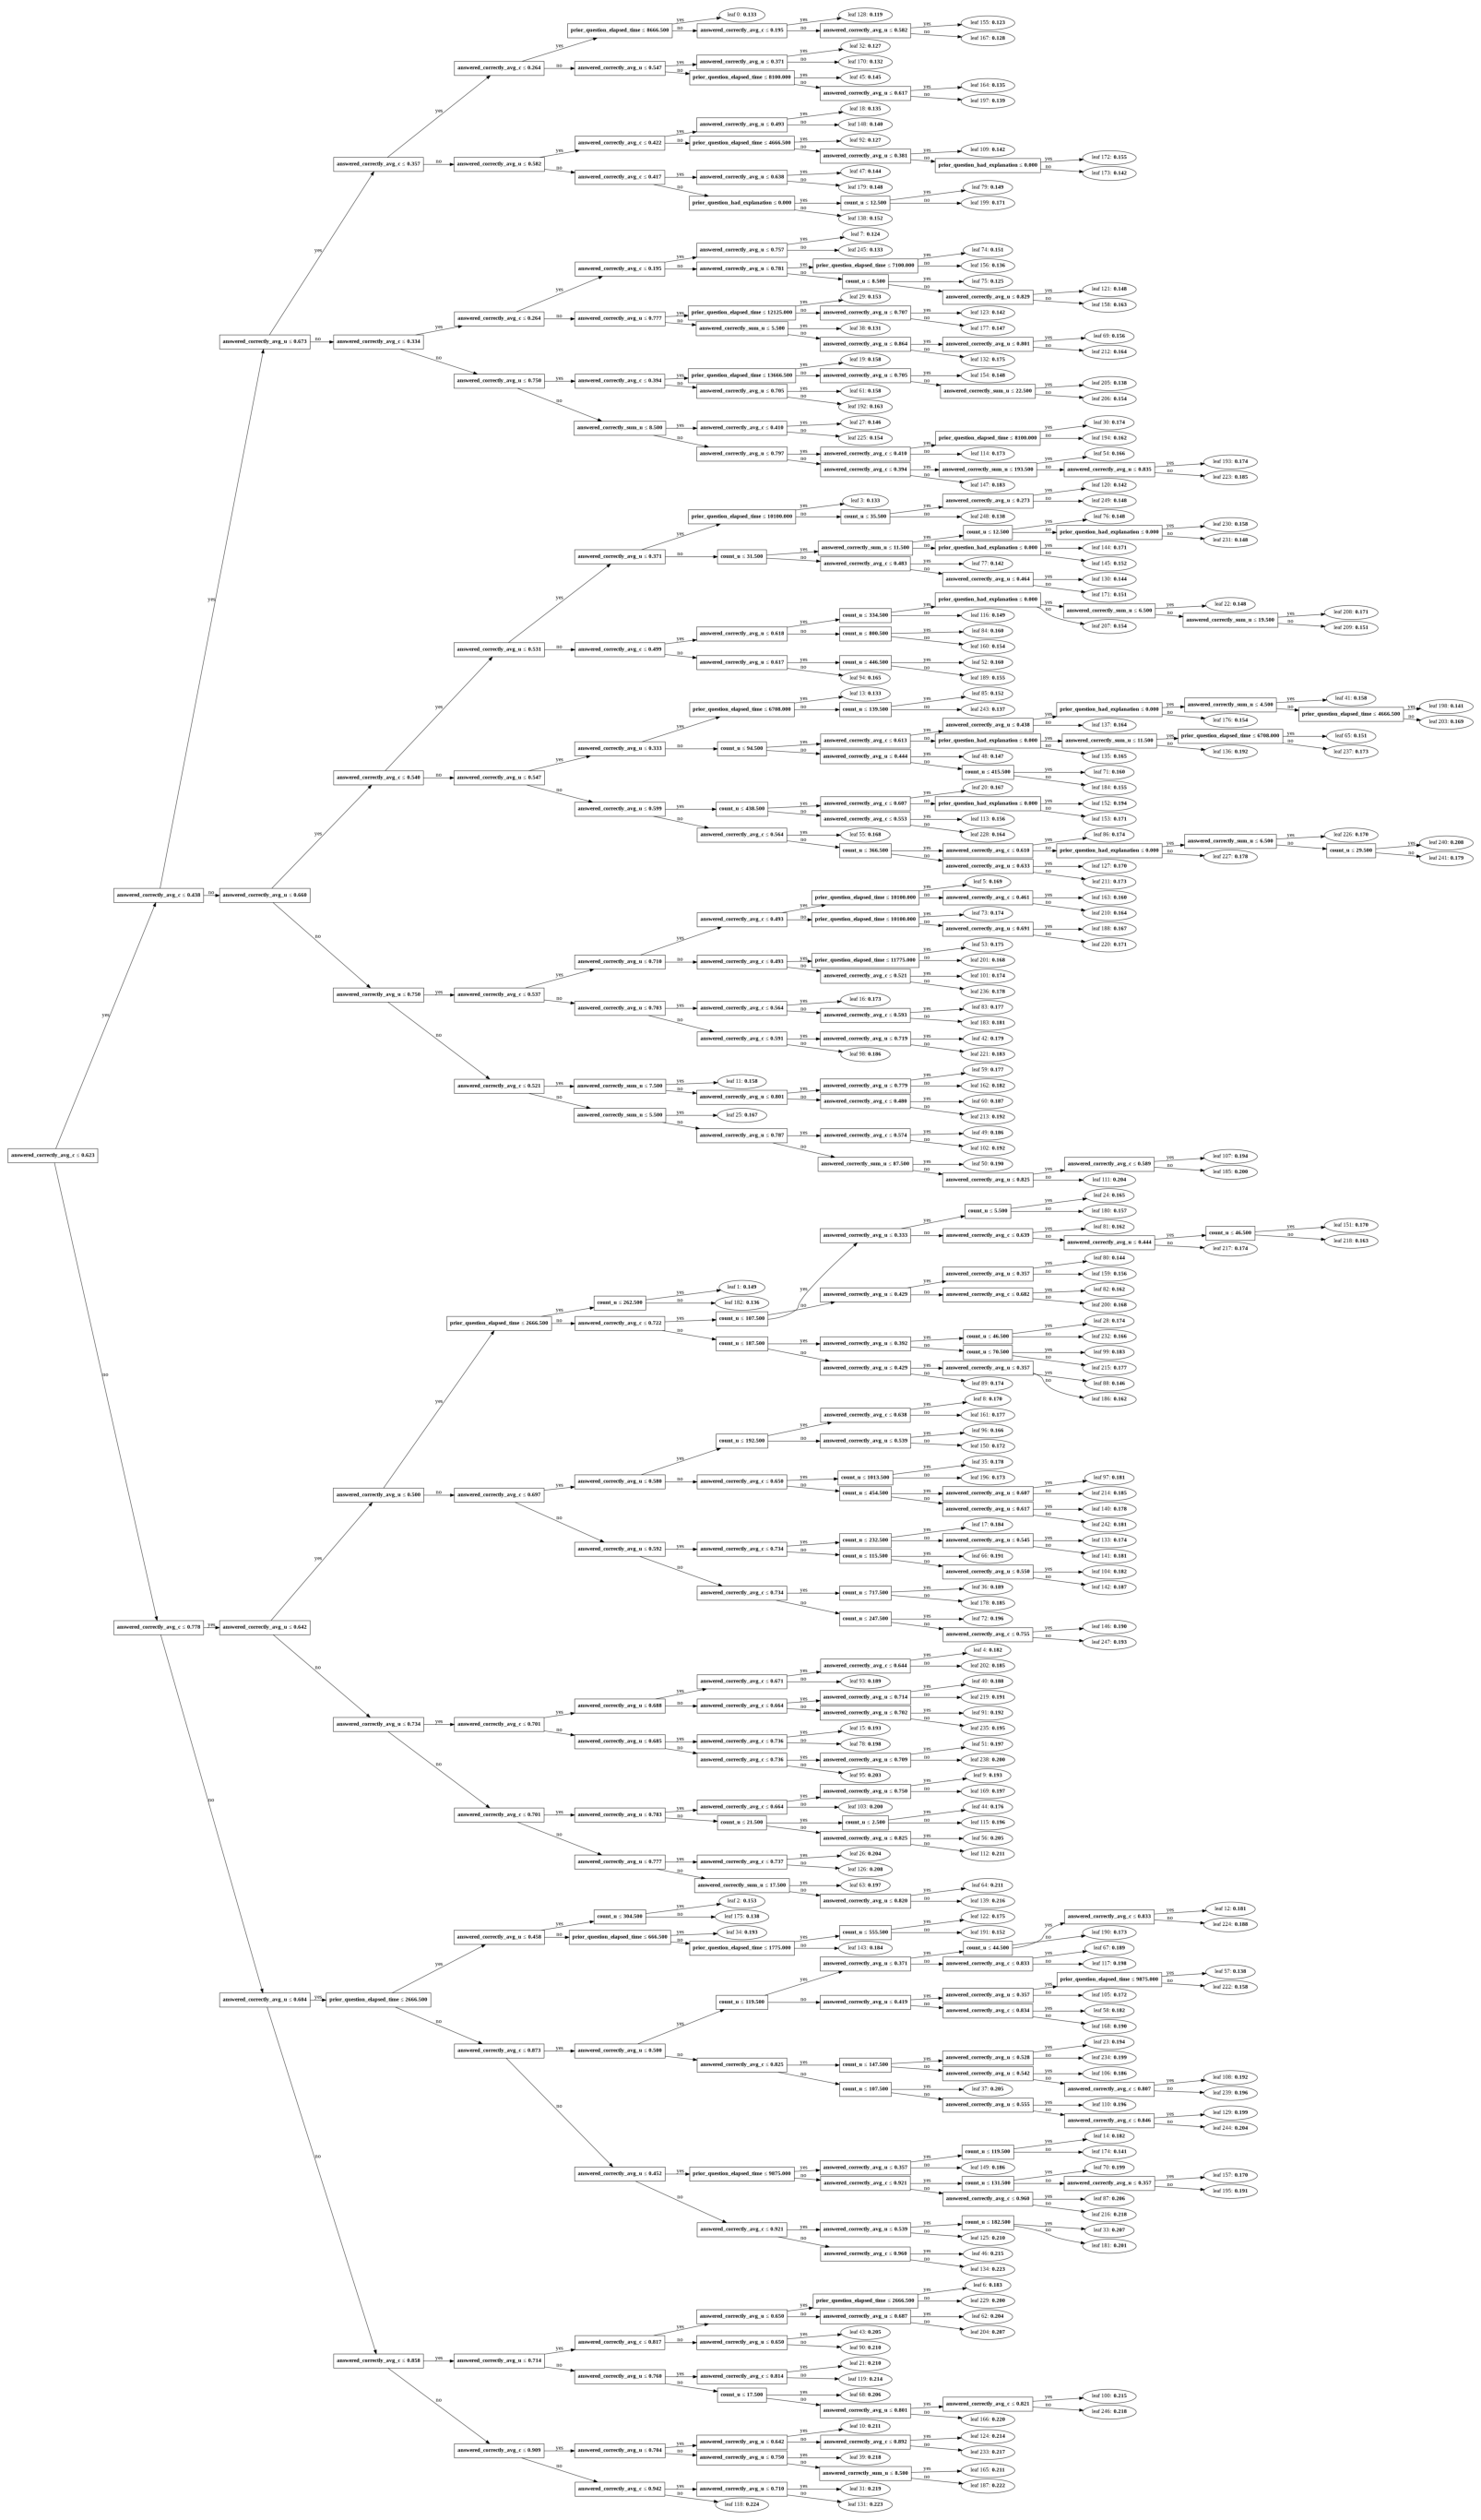

This function is completed.
ROC curve: 0.7624459229799384


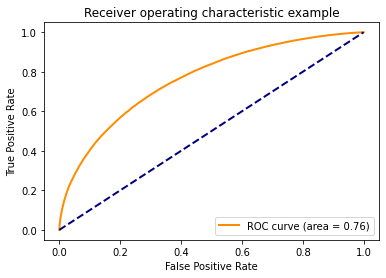

[I 2020-12-23 08:26:14,411] Trial 0 finished with value: 0.7624459229799384 and parameters: {'lambda_l1': 0.35947603308736487, 'lambda_l2': 0.7475637234313044, 'num_leaves': 250, 'feature_fraction': 0.8249047220063056, 'bagging_fraction': 0.9355666350618648, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 0 with value: 0.7624459229799384.


Operation completed.


In [21]:
# Optimize hyperparameters.
study = optuna.create_study(direction = 'maximize', sampler = sampler)
study.optimize(objective, n_trials = cpu_count(), n_jobs = cpu_count())

# The best model of LightGBM to train and validate:
1. Write .pickle about the best of all parameters;
1. Write the model.pickle to Kernel Notebook of Kaggle.
  - [Reference](https://blog.amedama.jp/entry/2018/05/08/033909)

In [22]:
params = {
        'objective': 'binary',
        'seed': SEED,
        'metric': 'AUC',
        'boosting_type': 'dart'
}
params.update(study.best_trial.params)
params = study.best_trial.params
print('The best:', params)

The best: {'lambda_l1': 0.35947603308736487, 'lambda_l2': 0.7475637234313044, 'num_leaves': 250, 'feature_fraction': 0.8249047220063056, 'bagging_fraction': 0.9355666350618648, 'bagging_freq': 6, 'min_child_samples': 17}


In [23]:
pickle.dump(params, open('The_best_of_all_parameters_on_LightGBM.pickle', 'wb'))
print('Save the best of parameters.')

Save the best of parameters.


# The results such simulation:
- [最適化の様子を可視化してみる: その２](https://qiita.com/studio_haneya/items/2dc3ba9d7cafa36ddffa#%E6%9C%80%E9%81%A9%E5%8C%96%E3%81%AE%E6%A7%98%E5%AD%90%E3%82%92%E5%8F%AF%E8%A6%96%E5%8C%96%E3%81%97%E3%81%A6%E3%81%BF%E3%82%8B-%E3%81%9D%E3%81%AE%EF%BC%92)
- [最適化の履歴を可視化できる。](https://fisproject.jp/2019/10/first-step-with-optuna-in-python/)

In [24]:
print('Number of finished trials:', len(study.trials))
print('The best of trials:', study.best_trial.params)

Number of finished trials: 2
The best of trials: {'lambda_l1': 0.35947603308736487, 'lambda_l2': 0.7475637234313044, 'num_leaves': 250, 'feature_fraction': 0.8249047220063056, 'bagging_fraction': 0.9355666350618648, 'bagging_freq': 6, 'min_child_samples': 17}


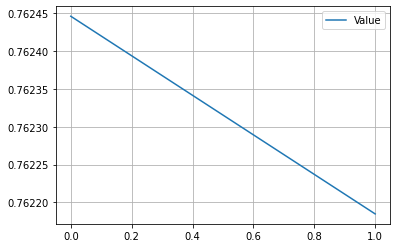

In [25]:
plt.plot([trial.value for trial in study.trials], label = 'Value')
plt.grid()
plt.legend()
plt.show()

In [26]:
plot_optimization_history(study)

In [27]:
plot_intermediate_values(study)

[W 2020-12-23 08:26:15,263] You need to set up the pruning feature to utilize `plot_intermediate_values()`


# Pointing out by [@tito](https://www.kaggle.com/its7171)
1. You can debug your inference code to reduce "Submission Scoring Error" with `validaten_flg = True`.
1. Please refer [Time-series API (iter_test) Emulator](https://www.kaggle.com/its7171/time-series-api-iter-test-emulator) about Time-series API (iter_test) Emulator.

# Validaten
1. You would like to focus on validation;
1. Set 'would like to';
1. And run following:

In [ ]:
if validaten_flg:
    target_df = pd.read_pickle(valid_pickle)
    if debug:
        target_df = target_df[:10000]
    iter_test = Iter_Valid(target_df,max_user=1000)
    predicted = []
    def set_predict(df):
        predicted.append(df)
    # reset answered_correctly_sum_u_dict and count_u_dict
    answered_correctly_sum_u_dict = defaultdict(int)
    count_u_dict = defaultdict(int)
    train = pd.read_pickle(train_pickle)[['user_id','answered_correctly','content_type_id']]
    if debug:
        train = train[:1000000]
    train = train[train.content_type_id == False].reset_index(drop=True)
    update_user_feats(train, answered_correctly_sum_u_dict, count_u_dict)
    del train
    y_true = target_df[target_df.content_type_id == 0].answered_correctly
    y_pred = pd.concat(predicted).answered_correctly
    print(roc_auc_score(y_true, y_pred))
    print(roc_curve(y_true, y_pred))

In [ ]:
print("Operation completed.")